In [212]:
import pandas as pd
import numpy as np
import os
import proplot as pplt
import sys
from sklearn.metrics import mean_squared_error, mean_absolute_error

module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
from ipv_workbench.utilities import utils, time_utils


In [216]:
interpolated_dir_2hr = "/Users/jmccarty/Data/221205_ipv_workbench/testing_interpolation/B1391_interpolate_2hr"
interpolated_dir_3hr = "/Users/jmccarty/Data/221205_ipv_workbench/testing_interpolation/B1391_interpolate_3hr"

full_run_dir = "/Users/jmccarty/Data/221205_ipv_workbench/testing_interpolation/B1391_full_run"

topology = "micro_inverter"

file_name = f"AP_solar_glass_2020_{topology}_building_level_results_hourly.csv"
full_run_name = f"AP_solar_glass_2020_{topology}_building_level_results_hourly_resolved.csv"

df_interp2hr = pd.read_csv(os.path.join(interpolated_dir_2hr,file_name),index_col="index")
df_interp2hr['HOY'] = np.arange(0,8760)
df_interp2hr.set_index(pd.to_datetime(df_interp2hr.index),drop=True,inplace=True)

df_interp3hr = pd.read_csv(os.path.join(interpolated_dir_3hr,file_name),index_col="index")
df_interp3hr['HOY'] = np.arange(0,8760)
df_interp3hr.set_index(pd.to_datetime(df_interp3hr.index),drop=True,inplace=True)


df_full = pd.read_csv(os.path.join(full_run_dir,full_run_name),index_col="index")
df_full.set_index(pd.to_datetime(df_full.index),drop=True,inplace=True)

In [137]:
sunup_file = "/Users/jmccarty/Desktop/bano_simulations/shared/resources/tmy/sun-up-hours.txt"
sun_up, sun_hours = utils.create_sun_mask(sunup_file)
sunup_array = sun_hours['HOY'].values
sundown_array = sun_up[sun_up['Sunny'] == False]['HOY'].values

In [217]:
def apply_nan(generation, hoy, interp_timeseries):
    if hoy in interp_timeseries.tolist():
        return np.nan
    else:
        return generation
    


interp_timeseries = time_utils.build_analysis_period(sunup_array,2)
df_interp2hr['raw_simulation_generation_kWh'] = df_interp2hr.apply(lambda x: apply_nan(x['electricity_gen_bulk_building_kwh'],x['HOY'],interp_timeseries),axis=1)
df_interp3hr['raw_simulation_generation_kWh'] = df_interp3hr.apply(lambda x: apply_nan(x['electricity_gen_bulk_building_kwh'],x['HOY'],interp_timeseries),axis=1)


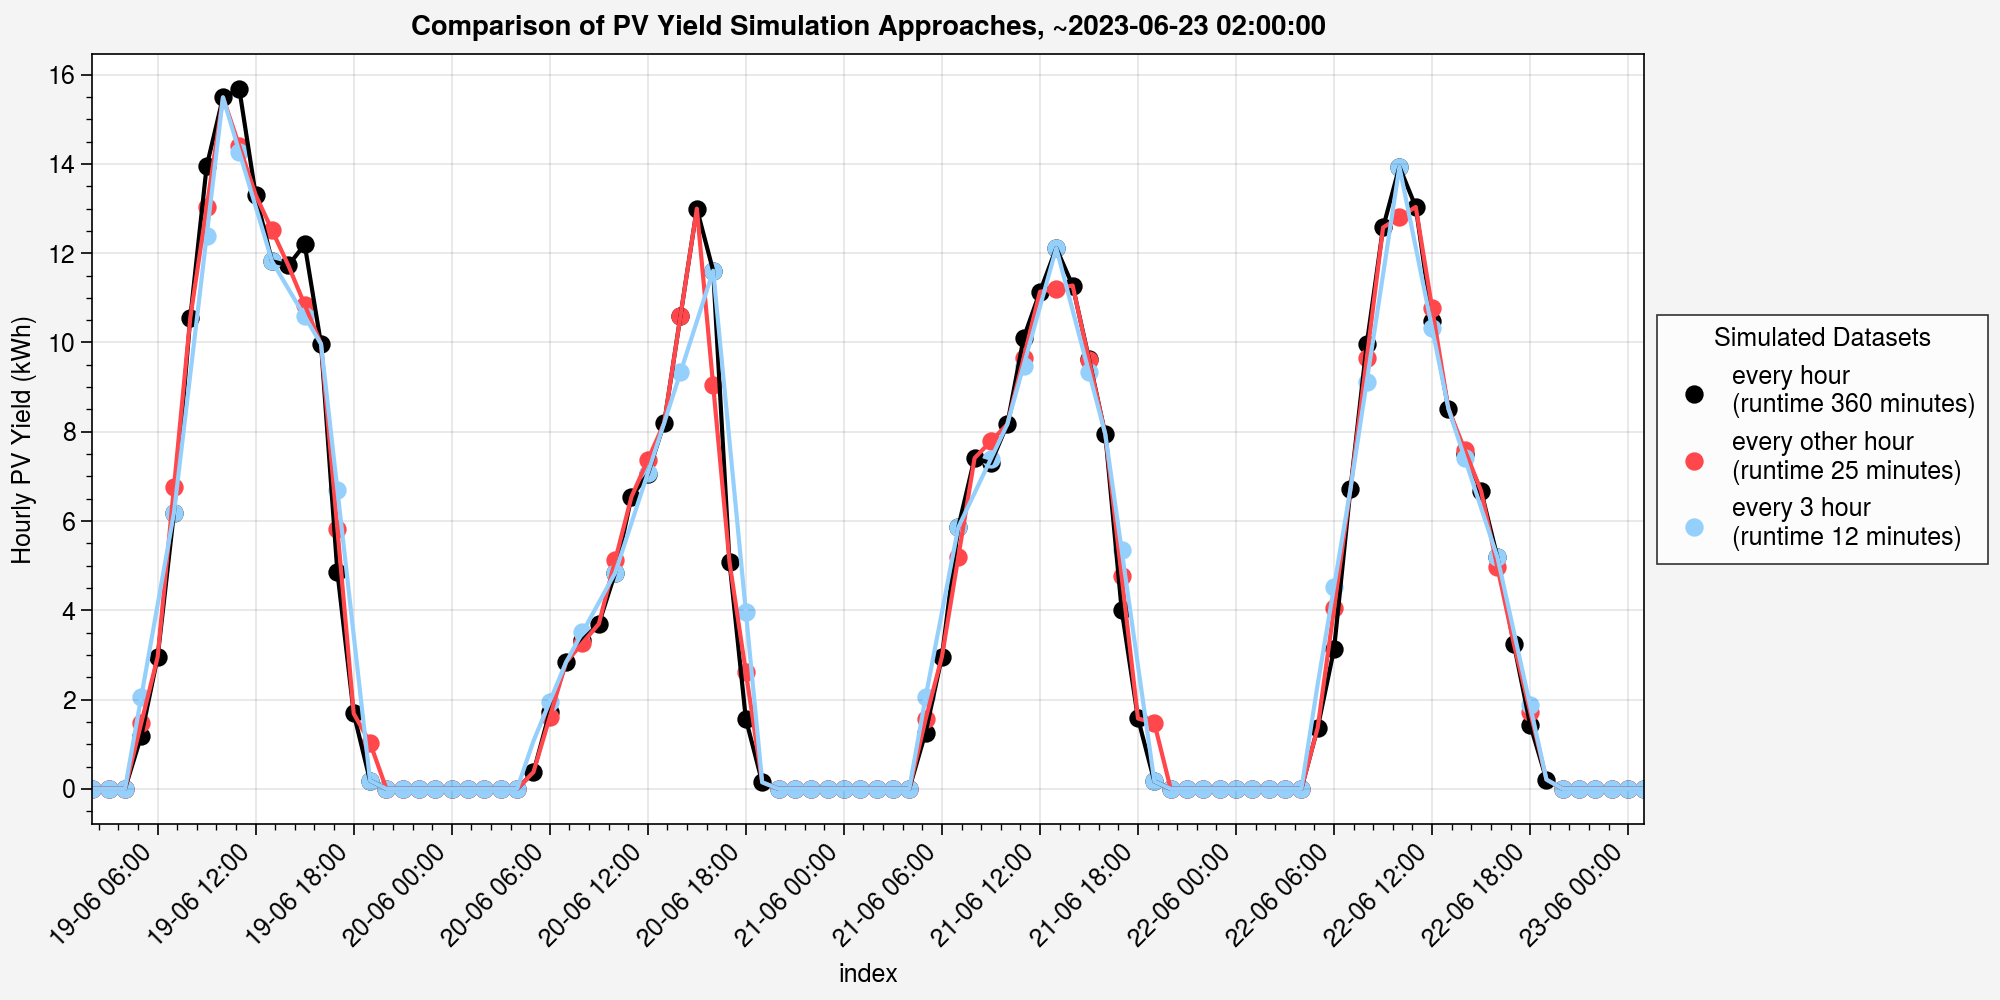

In [235]:
mid_time = 4106
plot_range = np.arange(mid_time-48,mid_time+48)


fig, axe  = pplt.subplots(ncols=1,nrows=1,figsize=(10,5))

ax = axe[0]

ax.scatter(x=df_full.iloc[plot_range].index,
           y=df_full.iloc[plot_range]['electricity_gen_bulk_building_kwh'],
           color='black',
           label='every hour\n(runtime 360 minutes)')

ax.scatter(x=df_interp2hr.iloc[plot_range].index,
           y=df_interp2hr.iloc[plot_range]['raw_simulation_generation_kWh'],
           color='light red',
           label='every other hour\n(runtime 25 minutes)')
ax.scatter(x=df_interp3hr.iloc[plot_range].index,
           y=df_interp3hr.iloc[plot_range]['raw_simulation_generation_kWh'],
           color='light blue',
           label='every 3 hour\n(runtime 12 minutes)')

axe.legend(loc='r',ncols=1,title="Simulated Datasets")

ax.line(x=df_full.iloc[plot_range].index,
           y=df_full.iloc[plot_range]['electricity_gen_bulk_building_kwh'],
           color='black')
ax.line(x=df_interp2hr.iloc[plot_range].index,
           y=df_interp2hr.iloc[plot_range]['electricity_gen_bulk_building_kwh'],
           color='light red')
ax.line(x=df_interp3hr.iloc[plot_range].index,
           y=df_interp3hr.iloc[plot_range]['electricity_gen_bulk_building_kwh'],
           color='light blue')

ax.format(ylabel="Hourly PV Yield (kWh)",
          xrotation=45,
          xlocator=('hour', range(0, 24, 6)), xformatter='%d-%m %H:%M',
          suptitle=f'Comparison of PV Yield Simulation Approaches, ~{time_utils.hoy_to_date(mid_time+48)}')



In [238]:


y_actual = df_full['electricity_gen_bulk_building_kwh']
y_predicted = df_interp3hr['electricity_gen_bulk_building_kwh']
rmse = mean_squared_error(y_actual, y_predicted, squared=True)
mae = mean_absolute_error(y_actual, y_predicted)


print(f"RMSE: {round(rmse,2)}, MAE: {round(mae,2)}")

RMSE: 1.12, MAE: 0.48


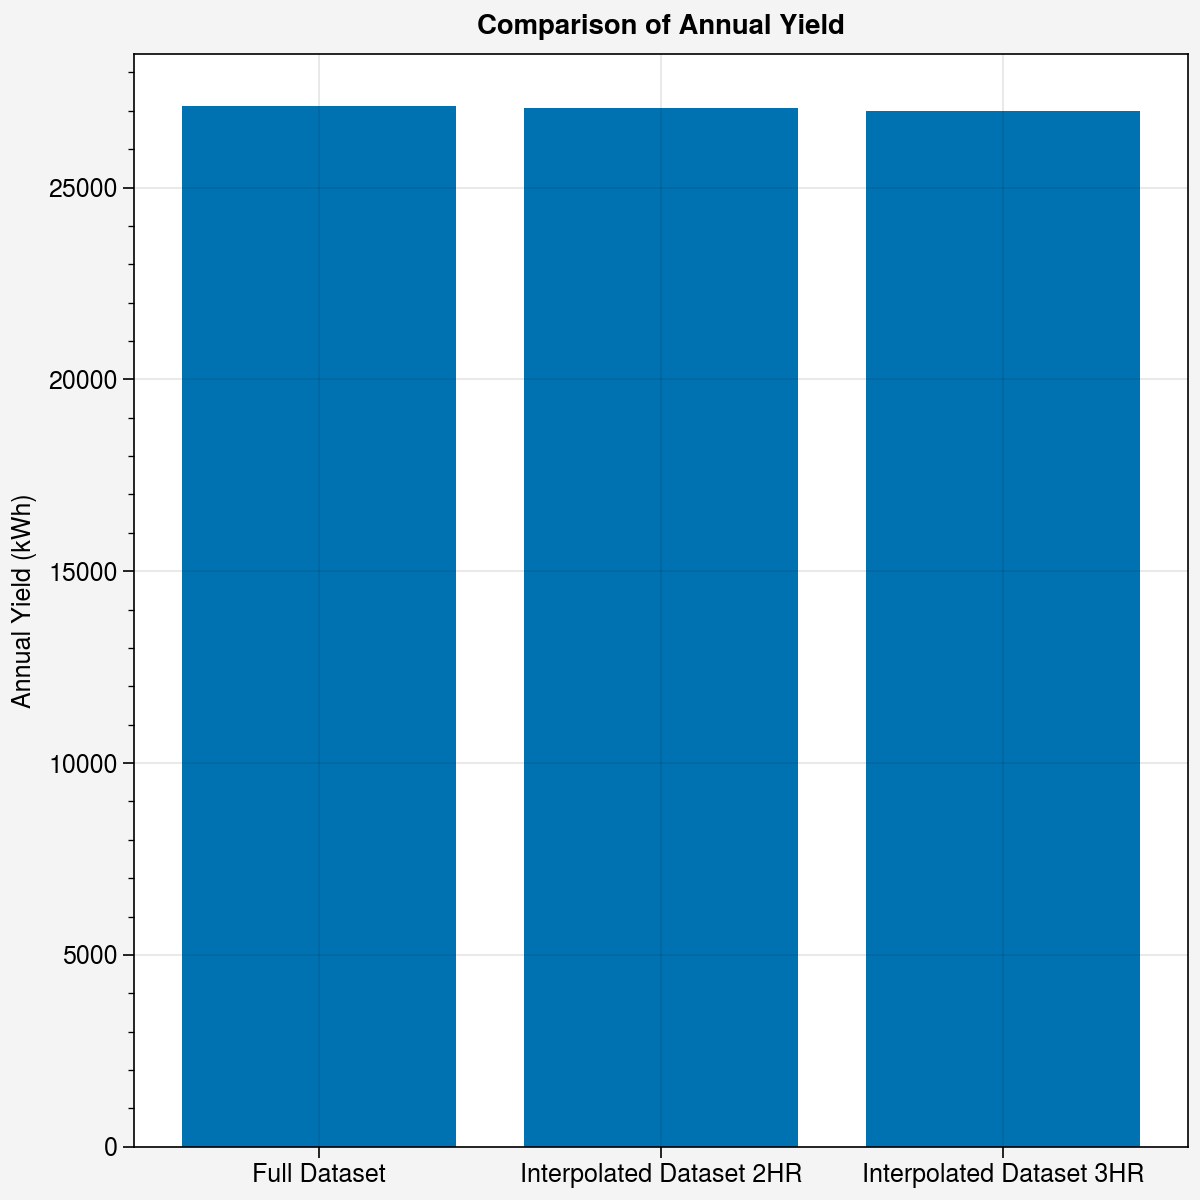

In [232]:


fig, axe = pplt.subplots(ncols=1,nrows=1, figsize=(6,6))
ax = axe[0]

x = ["Full Dataset",
     "Interpolated Dataset 2HR",
     "Interpolated Dataset 3HR"]
y = [df_full['electricity_gen_bulk_building_kwh'].sum(),
     df_interp2hr['electricity_gen_bulk_building_kwh'].sum(),
     df_interp3hr['electricity_gen_bulk_building_kwh'].sum()]
ax.bar(x, y, linewidth=0, alpha=1, width=0.8)
ax.format(ylabel='Annual Yield (kWh)',
          xlocator=1, suptitle='Comparison of Annual Yield')


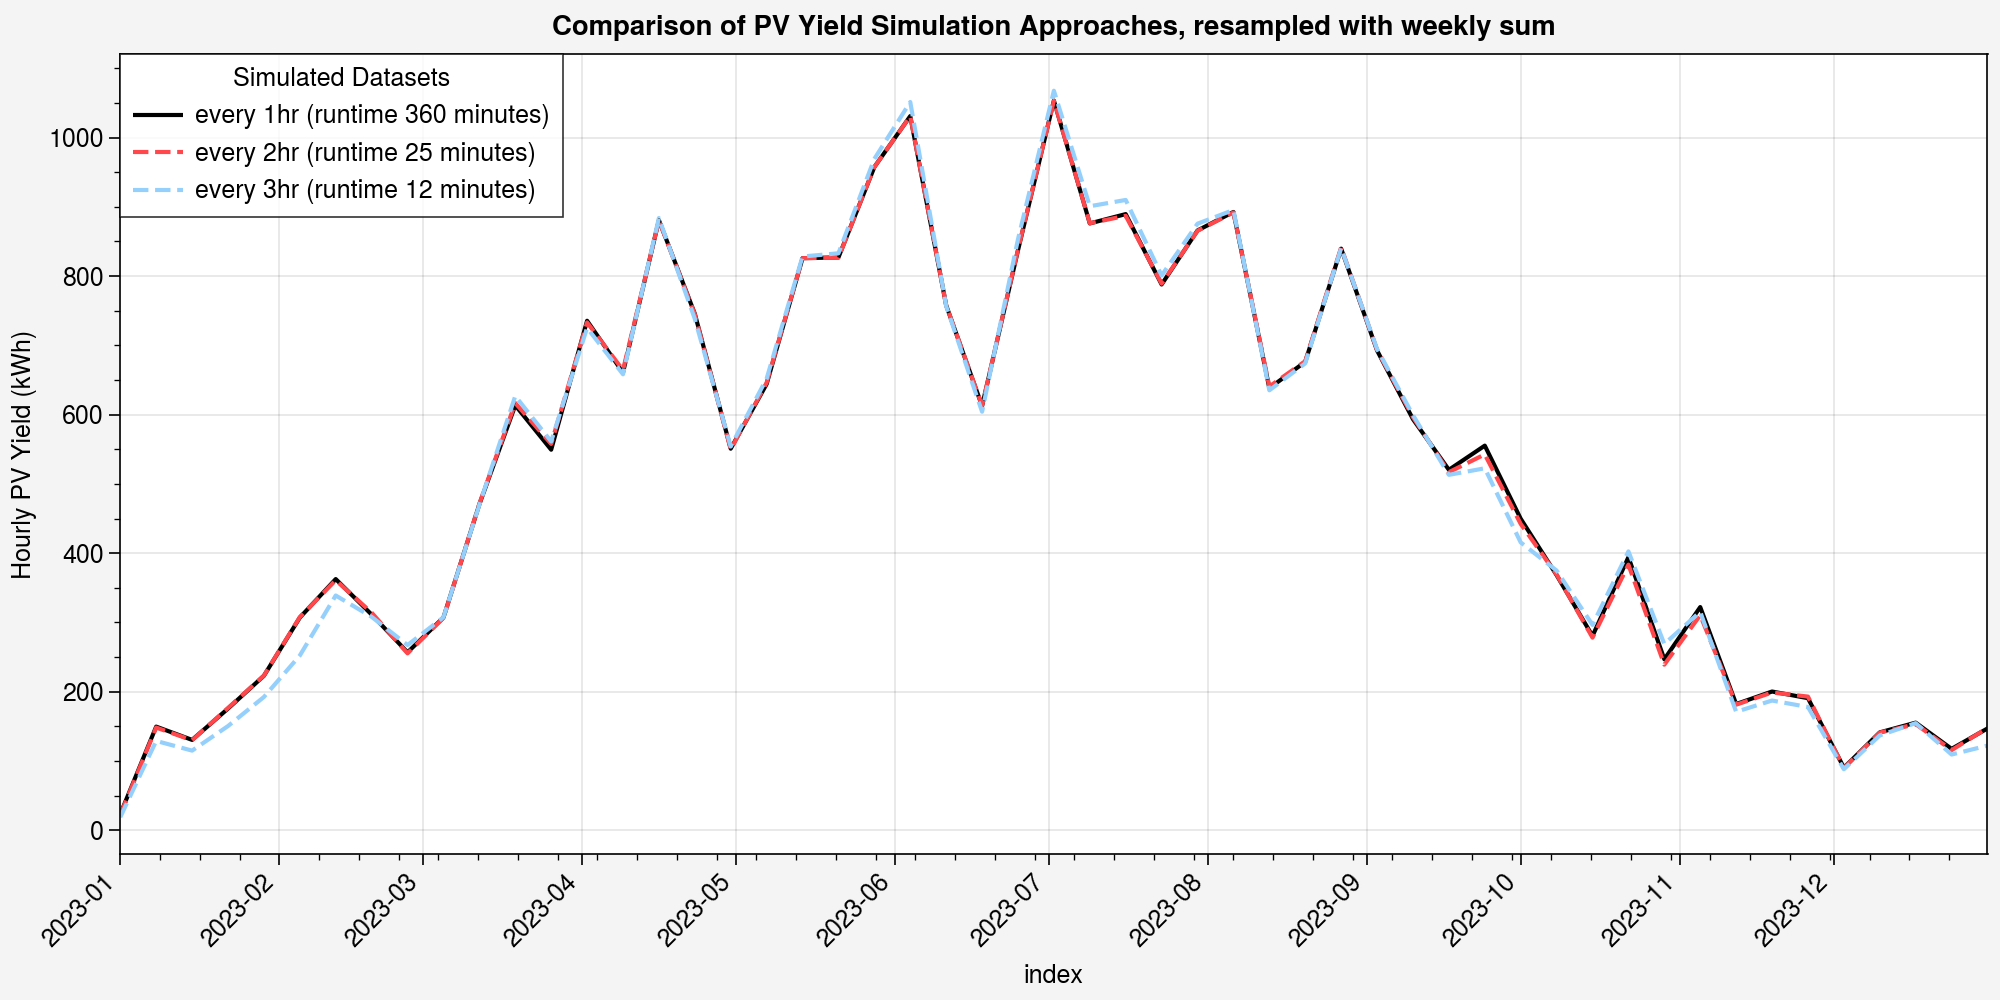

In [242]:
fig, axe  = pplt.subplots(ncols=1,nrows=1,figsize=(10,5))

ax = axe[0]

df_full_res = df_full.resample("W").sum()
df_interp2hr_res = df_interp2hr.resample("W").sum()
df_interp3hr_res = df_interp3hr.resample("W").sum()

ax.line(x=df_full_res.index,
           y=df_full_res['electricity_gen_bulk_building_kwh'],
           color='black',
           label='every 1hr (runtime 360 minutes)')
ax.line(x=df_interp2hr_res.index,
           y=df_interp2hr_res['electricity_gen_bulk_building_kwh'],
           color='light red',
           ls='dashed',
           label='every 2hr (runtime 25 minutes)')

ax.line(x=df_interp3hr_res.index,
           y=df_interp3hr_res['electricity_gen_bulk_building_kwh'],
           color='light blue',
           ls='dashed',
           label='every 3hr (runtime 12 minutes)')

axe.legend(loc='ul',ncols=1,title="Simulated Datasets")


ax.format(ylabel="Hourly PV Yield (kWh)",
          xrotation=45,
        #   xlocator=('hour', range(0, 24, 6)), xformatter='%d-%m %H:%M',
          suptitle=f'Comparison of PV Yield Simulation Approaches, resampled with weekly sum')

